<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "3B"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/3B/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


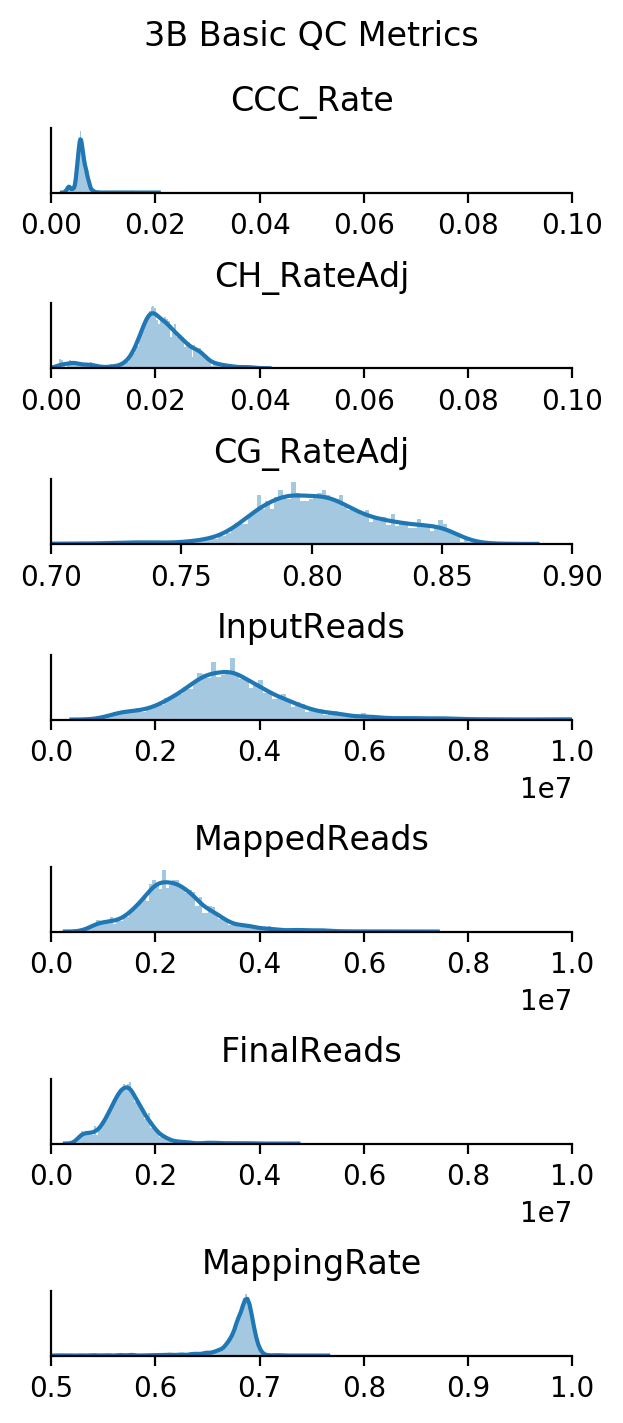

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

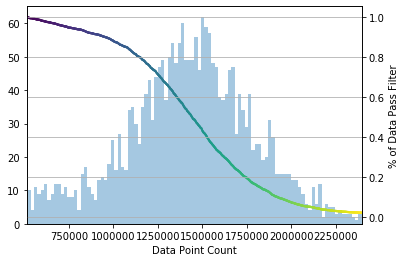

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2392/2392 (100.0%)
CG_RateAdj passed 2392/2392 (100.0%)
CH_RateAdj passed 2392/2392 (100.0%)
FinalReads passed 2392/2392 (100.0%)
MappingRate passed 2392/2392 (100.0%)
Overall passed 2392/2392 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180312 1291
180501 1101


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 312 81.2%
ad002 291 75.8%
ad004 303 78.9%
ad006 299 77.9%
ad007 293 76.3%
ad008 293 76.3%
ad010 308 80.2%
ad012 293 76.3%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
3B_M_0,/gale/raidix/rdx-4/CEMBA_RS1/3B/CEMBA180312_3B...,0.00657,0.82560,0.82445,0.03181,0.02541,1130169.0,2449658,1643910.0,3B,...,22.118933,10.244557,-35.368767,-37.755996,CT-L6 Il1rap,-3.057157,-16.758032,22.937203,-16.702083,True
3B_M_1,/gale/raidix/rdx-4/CEMBA_RS1/3B/CEMBA180312_3B...,0.00605,0.80185,0.80064,0.02735,0.02143,1354124.0,2964066,2020566.0,3B,...,13.778620,-5.950677,0.054602,-11.901614,IT-L6 Man1c1,-9.253384,-4.892591,6.415655,-19.600959,True
3B_M_10,/gale/raidix/rdx-4/CEMBA_RS1/3B/CEMBA180312_3B...,0.00577,0.79388,0.79268,0.02447,0.01881,1717710.0,3926388,2720333.0,3B,...,3.706657,-14.250229,-27.100801,8.028651,IT-L4 Shc3,-5.832239,3.323628,29.101425,23.506391,True
3B_M_100,/gale/raidix/rdx-4/CEMBA_RS1/3B/CEMBA180312_3B...,0.00658,0.80039,0.79907,0.03017,0.02375,1520638.0,3716540,2535323.0,3B,...,13.468756,-8.182643,17.972139,-8.692239,IT-L6 Fstl4,-8.987949,-0.489525,18.139013,16.909231,True
3B_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/3B/CEMBA180312_3B...,0.00532,0.81832,0.81735,0.02605,0.02084,1550462.0,3541584,2453796.0,3B,...,21.628834,8.013446,-41.757628,-32.242658,CT-L6 Il1rap,-6.500654,-17.699287,21.897709,5.700952,True
3B_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/3B/CEMBA180312_3B...,0.00741,0.84708,0.84594,0.04180,0.03465,1395569.0,3078802,2142600.0,3B,...,-28.263847,-0.080674,-50.747440,-18.892517,MGE-Sst Kcnip4,5.237830,-3.311696,12.317944,-19.680193,True
3B_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/3B/CEMBA180312_3B...,0.00574,0.82561,0.82460,0.02917,0.02357,1620243.0,3785874,2605239.0,3B,...,-26.479980,6.259320,5.591744,-30.557611,MGE-Pvalb Thsd7a,-3.864130,-5.841261,17.959261,-5.046600,True
3B_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/3B/CEMBA180312_3B...,0.00544,0.81305,0.81203,0.02676,0.02144,1700025.0,3992176,2750000.0,3B,...,24.497129,5.687357,-20.239573,-13.127266,CT-L6 Tnr,-7.497406,-23.546207,-39.186929,2.526380,True
3B_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/3B/CEMBA180312_3B...,0.00567,0.77346,0.77217,0.02581,0.02025,1571437.0,3610360,2496115.0,3B,...,-0.870308,-12.291525,-14.010166,47.119559,IT-L23 Cux1,1.640134,6.640269,18.700029,-11.314061,True
3B_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/3B/CEMBA180312_3B...,0.00512,0.78777,0.78668,0.02048,0.01544,1867628.0,4442224,3048782.0,3B,...,-2.284434,-9.415762,-28.540900,38.423844,IT-L23 Cux1,6.085003,4.516897,38.893856,1.247427,True
